# Analyzing an inspiral-merger-ringdown injection

This first cell must be executed first in order for Stan's multiprocessing code to not crash some MacOS setups; on linux it's not needed.

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import pandas as pd
import os
import seaborn as sns
import scipy.signal as ssig

import ringdown as rd
import wfutils

sns.set(context='notebook', palette='colorblind')

## Data

We will simulate detector data containing a signal and/or noise. As a starting point, construct a list of time-stamps for each detector; for simplicity, we can take this to be the same for all IFOs (this is usually be the case in real life).

In [4]:
# identify IFOs to simulate
ifos = ['H1']

# define center of time array (we will also use this as an injection time below)
tgps_geo = 1126259462.423

# define sampling rate and duration
fsamp = 8192
duration = 2

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))

epoch = tgps_geo - 0.5*tlen*delta_t

raw_time_dict = {i: np.arange(tlen)*delta_t + epoch for i in ifos}

### Signal

We can now create an injection using utilities in `wfutils`, which provides convenient wrappers for LAL funcitions.

In [5]:
wf_kws = dict(
    # define extrinsic source parameters
    ra = 1.952318922,
    dec = -1.26967171703,
    psi = 0.824043851821,
    inclination = 0.0,
    dist_mpc = 400,
    
    phi_ref = 2.41342424662,
    tgps_geocent = tgps_geo,
    
    # for NR waveform, f_low only used as f_ref
    f_low = 20.0,
    
    # define intrinsic source parameters
    # (no need to specify spins or q because we are using an NR waveform)
    mtot_msun = 72.0,

    # path to NR simulation in LALSuite format
    nr_path = os.path.join(os.getenv('HOME'),
                           'lscsoft/src/lvcnr-lfs/SXS/SXS_BBH_0305_Res6.h5'),
    approx='NR_hdf5',
    #ell = 0.3,
    #modes=[(2,2),(2,-2)]
)


# get waveform and auxiliary data (arrival times and antenna patterns)
# for diagnostics
raw_signal_dict, tgps_dict, ap_dict = wfutils.get_signal_dict(raw_time_dict, lal=True, **wf_kws)

# put signal in useful format so that we don't have to lug around a time array
raw_signal_dict = {i: rd.Data(h, index=raw_time_dict[i], ifo=i) 
                   for i,h in raw_signal_dict.items()}

Let's plot the signals we just simulated, and zoom around the merger:

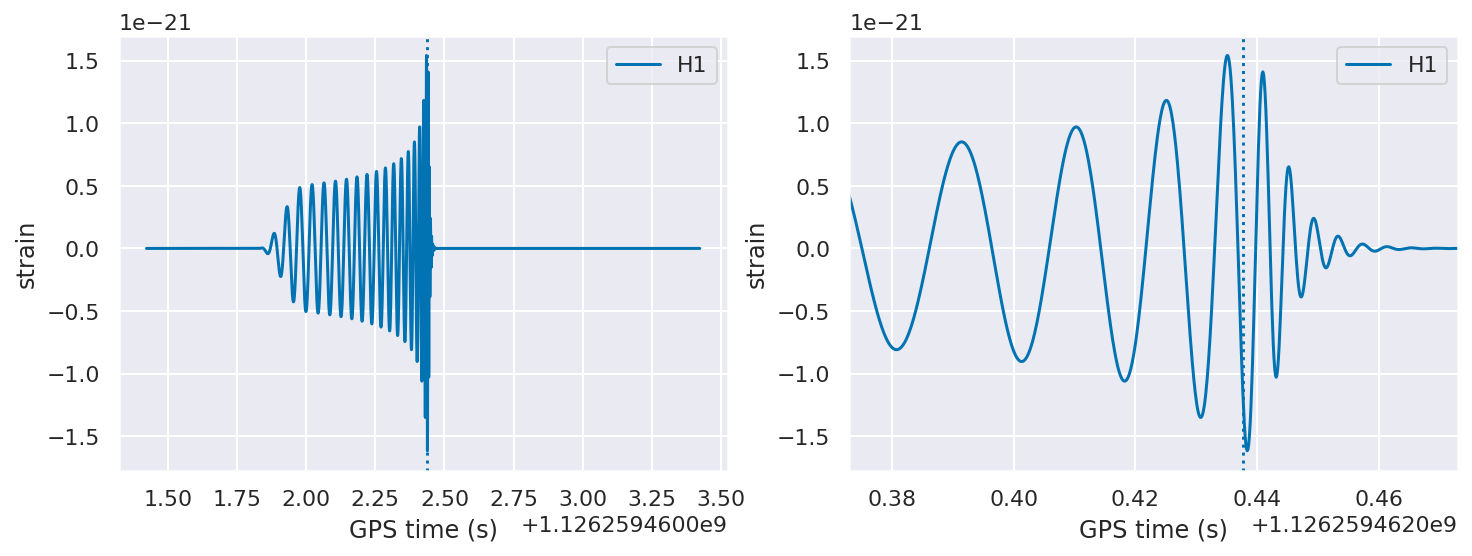

In [6]:
fig, axs = subplots(1, 2, figsize=(12,4))
for ifo, data in raw_signal_dict.items():
    for ax in axs:
        l, = ax.plot(data, label=ifo)
        ax.axvline(tgps_dict[ifo], ls=':', c=l.get_color())
    
        ax.set_xlabel("GPS time (s)")
        ax.set_ylabel("strain")
        ax.legend();

# zoom in for secondary axes
axs[-1].set_xlim(tgps_geo - 0.05, tgps_geo + 0.05);

### Noise

Now that we are done with the signal, we need to specify the noise at a each detector. First, let's define the PSD we want the noise to follow---we will use LALSim functions for simplicity, but we could easily load files from disk instead.

In [7]:
import lalsimulation as lalsim
from scipy.interpolate import interp1d
CE_ASD_DATA = np.genfromtxt("ce_asd.txt",unpack=True)
CE_psd = interp1d(CE_ASD_DATA[0], CE_ASD_DATA[1]**2, bounds_error=False, fill_value=1.0)
psd_func_dict = {
    'H1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,#CE_psd,#
    'L1': lalsim.SimNoisePSDaLIGOZeroDetHighPower,
    'V1': lalsim.SimNoisePSDAdvVirgo,
}

To instantiate the PSD, we need an array of frequencies corresponding to the time series data we constructed above.

In [8]:
freqs = fft.rfftfreq(tlen, delta_t)

# we will want to pad low frequencies
fmin = 5
def pad_low_freqs(f, psd_ref):
    return psd_ref + psd_ref*(fmin-f)*np.exp(-(fmin-f))/3

psd_dict = {}
for ifo in ifos:
    psd = np.zeros(len(freqs))
    for i,f in enumerate(freqs):
        if f >= fmin:
            psd[i] = psd_func_dict[ifo](f)
        else:
            psd[i] = pad_low_freqs(f, psd_func_dict[ifo](fmin))
    psd_dict[ifo] = rd.PowerSpectrum(psd, index=freqs)

Let's plot the resulting ASDs and compare to the FD signal.

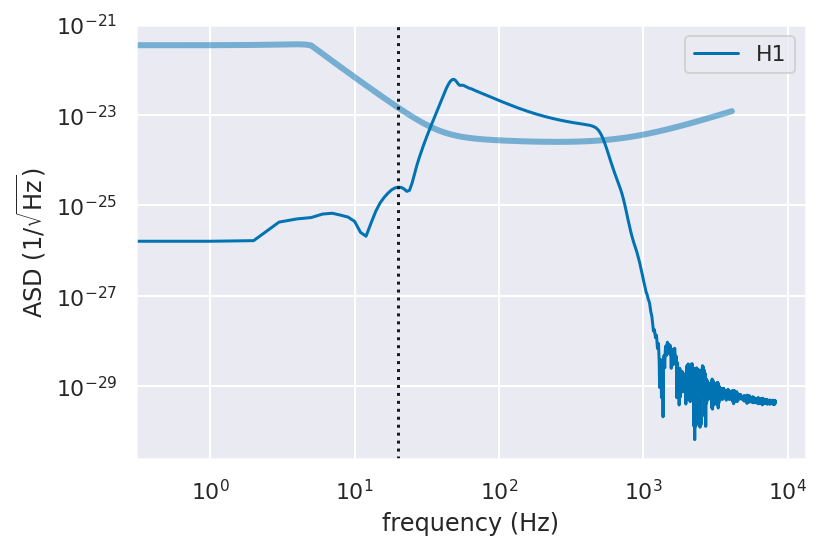

In [9]:
for ifo, psd in psd_dict.items():
    dfd = fft.rfft(raw_signal_dict[ifo]) * delta_t
    l, = loglog(abs(dfd), label=ifo,)
    loglog(sqrt(psd / (4*psd.delta_f)), lw=3, alpha=0.5, c=l.get_color())

for k in ['f_low', 'f_ref']:
    if k in wf_kws:
        axvline(wf_kws[k], ls=':', c='k')
xlabel("frequency (Hz)");
ylabel(r"ASD ($1/\sqrt{\rm Hz}$)");
legend();

For our ringdown analysis, we will need the ACFs corresponding to these PSDs. We can obtain this straightforwardly by FFTing, _as long as the ringdown analysis segment is much shorter than the duration simulated above_.

In [10]:
acf_dict = {i: psd.to_acf() for i, psd in psd_dict.items()}

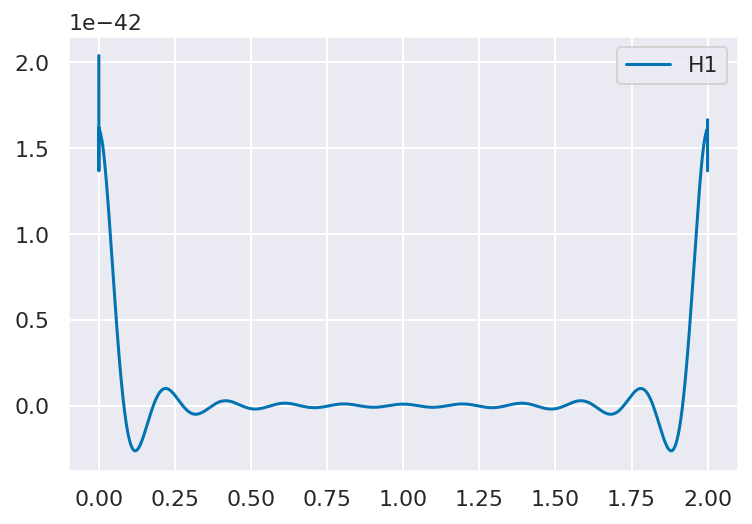

In [11]:
for ifo, acf in acf_dict.items():
    plot(acf, label=ifo)
legend();

#### Adding noise to data

If we are not doing a no-noise simulation, then we should add noise to the data; this should match the PSD above. To do this, first simulate noise with the right variance, $S(f)/(4 \Delta f)$, in the Fourier domain and then IFFT back into the time domain.

In [12]:
np.random.seed(1234)

noise_fd_dict = {}
for ifo, psd in psd_dict.items():
    var = psd / (4.*psd.delta_f)  # this is the variance of LIGO noise given the definition of the likelihood function
    noise_real = np.random.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_imag = np.random.normal(size=len(psd), loc=0, scale=np.sqrt(var))
    noise_fd_dict[ifo] = noise_real + 1j*noise_imag

In [13]:
# IFFT into the time domain

noise_td_dict = {}
for ifo, noise_fd in noise_fd_dict.items():
    noise_td_dict[ifo] = fft.irfft(noise_fd) / delta_t

As a sanity check, let's manually compute the PSD from the simulated data using Welch and compare to the one we prescribed.

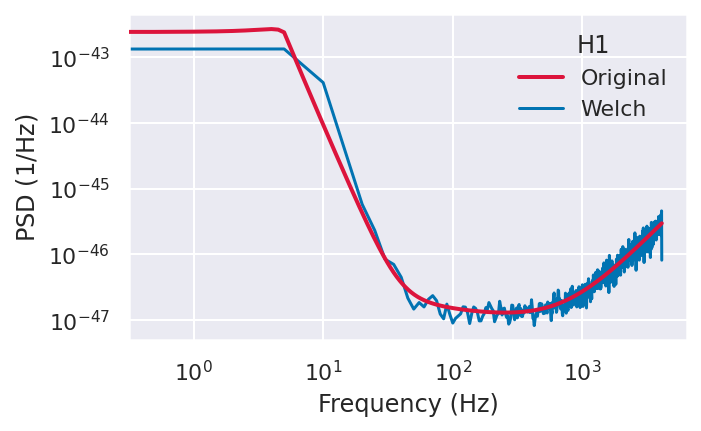

In [14]:
fig, axs = subplots(1, len(ifos), figsize=(5*len(ifos), 3))
if len(ifos)==1: axs = [axs]
for ax, (ifo, noise) in zip(axs, noise_td_dict.items()):
    # compute Welch PSD
    psd_freq, psd_data = ssig.welch(noise, fs=1./delta_t, nperseg=0.1*duration/delta_t)
    
    ax.loglog(freqs, psd_dict[ifo], label='Original', c='crimson', lw=2, zorder=100)
    ax.loglog(psd_freq, psd_data, label='Welch')
    ax.legend(loc='upper right', frameon=False, title=ifo);
    ax.set_xlabel("Frequency (Hz)");
    # ax.set_ylim(1E-47, 1E-46)
axs[0].set_ylabel(r"PSD ($1/\mathrm{Hz}$)");

Now, let's acutally add noise to the data **WARNING: don't do this if no-noise.**

In [15]:
no_noise = True

if no_noise:
    raw_data_dict = raw_signal_dict.copy()
else:
    # add zero-mean noise to the data
    raw_data_dict = {i: raw_signal_dict[i] + n - mean(n) 
                     for i,n in noise_td_dict.items()}

For sanity, let's look at the data whitened with the ACF and the PSD.

In [16]:
noisy_data_dict = {i: raw_signal_dict[i] + n - mean(n)
                   for i,n in noise_td_dict.items()}

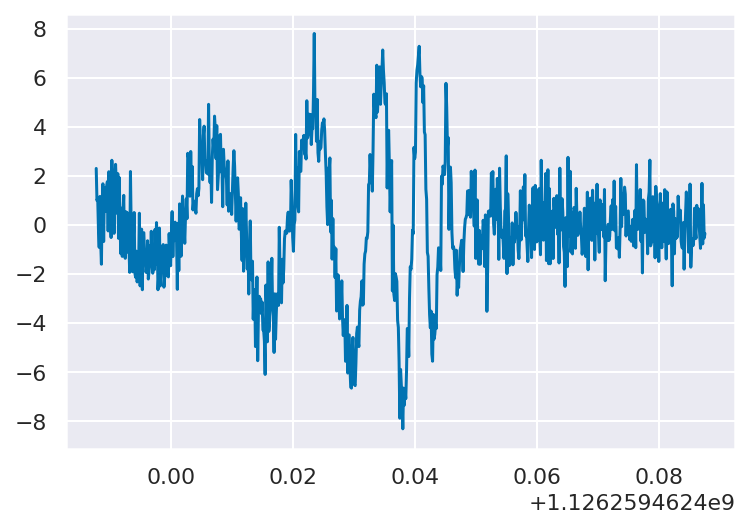

In [17]:
for i, data in noisy_data_dict.items():
    # select data around the injection, or this will take forever
    d = data[abs(data.time - tgps_dict[i]) < 0.05]
    plot(acf.whiten(d))

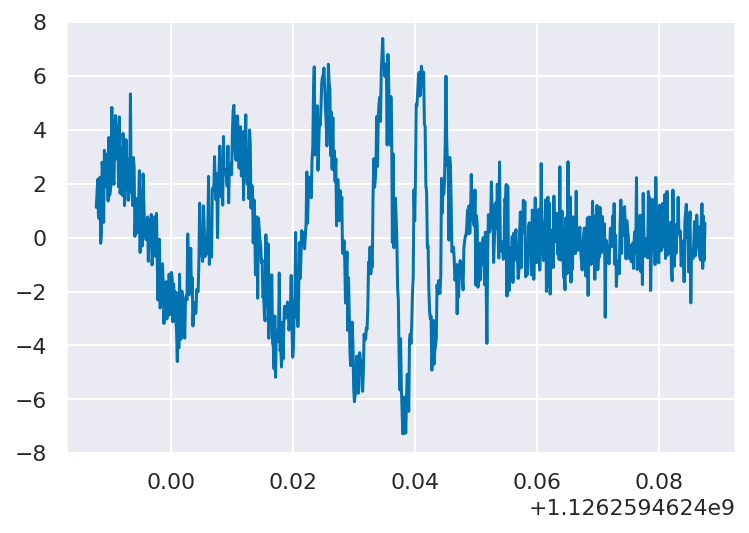

In [18]:
for i, data in noisy_data_dict.items():
    data_fd = fft.rfft(data)
    var = psd_dict[i] / (4*psd_dict[i].delta_f)
    w_data = fft.irfft(data_fd/sqrt(var)) / sqrt(0.5*tlen)
    m = abs(raw_time_dict[i] - tgps_dict[i]) < 0.05
    plot(raw_time_dict[i][m], w_data[m])

## Fit

We are now ready to analyze the ringdown! Let's create a fit object and set up the analysis. To begin with, I'm going to use the generic polarization `mchi` model and fit only the fundamental quadrupolar prograde mode ($p=1, s=-2, \ell=2, |m|=2, n=0$).

In [19]:
#fit = rd.Fit(modes=[(1, -2, 2, 2, 0),(1,-2,2,2,1),(1,-2,2,2,2),(1,-2,2,2,3),(1,-2,2,2,4),(1,-2,2,2,5),(1,-2,2,2,6),(1,-2,2,2,7),(1,-2,2,2,8),(1,-2,2,2,9),(1,-2,2,2,10),(1,-2,2,2,11)])
fit = rd.Fit()
fit.set_tone_sequence(8)

Since we already have the data and ACFs, we can add those directly to the fit now.

In [20]:
fit.data = raw_data_dict.copy()
fit.acfs = acf_dict.copy()

Now, let's specify a target for the analysis. Since we are using just the fundamental mode, we will want to start a few $M$ after the peak.

In [21]:
# get M in seconds (approximating remnant mass as 95% the total mass)
# TODO: this should be fixed to be the actual remnant mass from the NR sim
tM = 0.9525*wf_kws['mtot_msun']*rd.qnms.T_MSUN

# the start time for the ringdown model
t0 = tgps_geo + 0*tM

# collect sky location arguments
skyloc = {k: wf_kws[k] for k in ['ra', 'dec', 'psi']}

fit.set_target(t0, duration=0.2, **skyloc)

In [22]:
fit.target, fit.duration

(Target(t0=1126259462.423, ra=1.952318922, dec=-1.26967171703, psi=0.824043851821),
 0.2)

Let's set some reasonable prior based on our knowledge of the true signal.

In [23]:
fit.update_prior(A_scale=5e-21, M_min=40.0, M_max=80.0, chi_max=0.8)

In [24]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'perturb_tau': array([0., 0., 0., 0., 0., 0., 0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 40.0,
 'M_max': 80.0,
 'chi_min': 0,
 'chi_max': 0.8,
 'flat_A_ellip': 0}

Our fit is ready to go; run it!

(The `run()` method will automatically compile the `PyStan` code the first time any fit runs in a given session, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.)

In [ ]:
fit.run()

Running mchi

Gradient evaluation took 0.51 seconds
1000 transitions using 10 leapfrog steps per transition would take 5100 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.62 seconds
1000 transitions using 10 leapfrog steps per transition would take 6200 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.51 seconds
1000 transitions using 10 leapfrog steps per transition would take 5100 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.56 seconds
1000 transitions using 10 leapfrog steps per transition would take 5600 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)


`fit.result` contains an arviz object giving our results:

In [ ]:
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

We can plot a trace, and see visually that the sampling seems OK:

In [ ]:
az.plot_trace(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'f', 'tau'], compact=True);

In [ ]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

# plot true values
pg.axes[1,0].axvline(wf_kws['mtot_msun']*0.952)
pg.axes[1,0].axhline(0.692)

Get mean signal reconstructions at each detector and plot them against the truth.

In [ ]:
# median reconstruction and 90%-credible envelope
rec_wf_dict = {}
for i, ifo in enumerate(ifos):
    wfs = [quantile(fit.result.posterior.h_det.values, q, axis=(0,1))[i,:] 
           for q in [0.5, 0.95, 0.05]]
    rec_wf_dict[ifo] = [rd.Data(wf, ifo=ifo, index=fit.analysis_data[ifo].time) 
                        for wf in wfs]

In [ ]:
for ifo, (m, u, d) in rec_wf_dict.items():
    # plot reconstructions
    l, = plot(m, label=ifo)
    fill_between(m.time, u, d, color=l.get_color(), alpha=0.25)
    
    # plot truth (using time mask to select right times)
    tm = (min(m.time) <= raw_time_dict[ifo]) & (max(m.time) >= raw_time_dict[ifo])
    plot(raw_time_dict[ifo][tm], raw_signal_dict[ifo][tm], 
         c=l.get_color(), ls='--')
legend();

It's usually more instructive to plot the _whitened_ data and reconstructions:

In [ ]:
for ifo, m_u_d in rec_wf_dict.items():
    # whiten reconstructions
    wm, wu, wd = [fit.acfs[ifo].whiten(x) for x in m_u_d]
    # plot reconstructions
    l, = plot(wm, label=ifo)
    fill_between(wm.time, wu, wd, color=l.get_color(), alpha=0.25)
    
    # plot whitened truth (using time mask to select right times)
    tm = (min(wm.time) <= raw_time_dict[ifo]) & (max(wm.time) >= raw_time_dict[ifo])
    wsig = fit.acfs[ifo].whiten(raw_signal_dict[ifo][tm])
    plot(raw_time_dict[ifo][tm], wsig, c=l.get_color(), ls='--')
    
    # plot whitened data
    wdata = fit.acfs[ifo].whiten(fit.analysis_data[ifo])
    errorbar(fit.analysis_data[ifo].time, wdata, yerr=ones(len(wdata)), alpha=0.5,
             c=l.get_color(), fmt='.', zorder=-100, elinewidth=0.5, ms=4)
legend();

Let's compute the recovered  matched filter SNR. We can obtain a posterior on the recovered matched filter SNR by computing this quantity from random draws of the the posterior.

In [ ]:
# first flatten chains
hs_nd = fit.result.posterior.h_det.values
hs = hs_nd.reshape((-1, hs_nd.shape[2], hs_nd.shape[3]))

# now pick N random reconstructions and compute SNR
netsnrs = []
for n in randint(0, hs.shape[0], 1000):
    snrs = [acf.compute_snr(hs[n,i,:], fit.analysis_data[ifo]) 
            for i,(ifo,acf) in enumerate(fit.acfs.items())]
    netsnrs.append(linalg.norm(snrs))

In [ ]:
# compute injected SNR for reference
snrs = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    tm = (min(fit.analysis_data[ifo].time) <= raw_time_dict[ifo]) &\
         (max(fit.analysis_data[ifo].time) >= raw_time_dict[ifo])
    snrs.append(acf.compute_snr(raw_signal_dict[ifo][tm], fit.analysis_data[ifo]) )
netsnr_inj = linalg.norm(snrs)

In [ ]:
sns.kdeplot(netsnrs)
axvline(netsnr_inj, ls='--');
xlabel('matched filter network SNR');

That looks good. For completeness, repeat for the _optimal_ SNR.

In [ ]:
# now pick N random reconstructions and compute SNR
netsnrs_opt = []
for n in randint(0, hs.shape[0], 1000):
    snrs = [acf.compute_snr(hs[n,i,:]) for i,(ifo,acf) in enumerate(fit.acfs.items())]
    netsnrs_opt.append(linalg.norm(snrs))

In [ ]:
# compute injected SNR for reference
snrs = []
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    tm = (min(fit.analysis_data[ifo].time) <= raw_time_dict[ifo]) &\
         (max(fit.analysis_data[ifo].time) >= raw_time_dict[ifo])
    snrs.append(acf.compute_snr(raw_signal_dict[ifo][tm]) )
netsnr_inj_opt = linalg.norm(snrs)

In [ ]:
sns.kdeplot(netsnrs_opt)
axvline(netsnr_inj_opt, ls='--');
xlabel('optimal network SNR');

In [ ]:
print(netsnr_inj, netsnr_inj_opt)

If you want, you can save the fit result to disk as follows:

In [ ]:
fit.result.to_netcdf('myfit.nc')

In [ ]:
# you can load that by doing:
cached_result = az.from_netcdf('myfit.nc')